# How to Train YOLOv10 Object Detection on a Custom Dataset

---

[![arXiv](https://img.shields.io/badge/arXiv-2405.14458-b31b1b.svg)](https://arxiv.org/pdf/2405.14458.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/THU-MIG/yolov10)
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/YOLO-ARENA)

YOLOv10 is a new generation in the YOLO series for real-time end-to-end object detection. It aims to improve both the performance and efficiency of YOLOs by eliminating the need for non-maximum suppression (NMS) and optimizing model architecture comprehensively. This advancement reduces computational overhead, enhancing both efficiency and capability. YOLOv10 shows state-of-the-art performance and efficiency, with YOLOv10-S being 1.8 times faster than RT-DETR-R18 and having significantly fewer parameters and FLOPs. Additionally, YOLOv10-B demonstrates 46% less latency and 25% fewer parameters compared to YOLOv9-C while maintaining the same performance.

<p align="center">
  <img src="docs/yolov10/yolov10_latency.svg" width=48%>
  <img src="docs/yolov10/yolov10_params.svg" width=48%> <br>
  Comparisons with others in terms of latency-accuracy (left) and size-accuracy (right) trade-offs.
</p>

In [9]:
import os

WORKSPACE = os.path.abspath("./workspace")
print(WORKSPACE)

# Copy the dataset into WORKSPACE/datset
DATASET_PATH = os.path.join(WORKSPACE, "dataset")

/home/vietanhdev/Workspace/Me/anylearning/notebooks/workspace


## Install YOLOv10 + Dependencies

**NOTE:** Currently, YOLOv10 does not have its own PyPI package. Therefore, we need to install the code from the source.

In [2]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git
!pip install huggingface_hub supervision

## Download pre-trained weights

**NOTE:** YOLOv10 provides weight files pre-trained on the COCO dataset in various sizes. Let's download them.

In [10]:
!mkdir -p {WORKSPACE}/weights
!wget -P {WORKSPACE}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {WORKSPACE}/weights

total 11M
-rw-rw-r-- 1 vietanhdev vietanhdev 11M Thg 5  26 22:54 yolov10n.pt


## Custom Training

In [11]:
!yolo task=detect mode=train epochs=10 batch=32 plots=True \
model={WORKSPACE}/weights/yolov10n.pt \
data={DATASET_PATH}/dataset.yaml

/home/vietanhdev/miniconda3/envs/anylearning/lib/python3.12/site-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, 

In [14]:
!ls runs/detect/train/

args.yaml			 PR_curve.png	   val_batch0_labels.jpg
confusion_matrix_normalized.png  R_curve.png	   val_batch0_pred.jpg
confusion_matrix.png		 results.csv	   val_batch1_labels.jpg
F1_curve.png			 results.png	   val_batch1_pred.jpg
labels_correlogram.jpg		 train_batch0.jpg  weights
labels.jpg			 train_batch1.jpg
P_curve.png			 train_batch2.jpg


## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.

In [15]:
from ultralytics import YOLOv10
import supervision as sv

model = YOLOv10(f'runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{DATASET_PATH}/val/images",
    annotations_directory_path=f"{DATASET_PATH}/val/labels",
    data_yaml_path=f"{DATASET_PATH}/dataset.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


**NOTE:** Let's randomly select an image from our validation set and visualize the results.

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 640x640 5 tuongs, 2 vuas, 10 tots, 3 phaos, 3 sis, 3 xes, 6 mas, 4.8ms
Speed: 2.7ms preprocess, 4.8ms inference, 66.3ms postprocess per image at shape (1, 3, 640, 640)


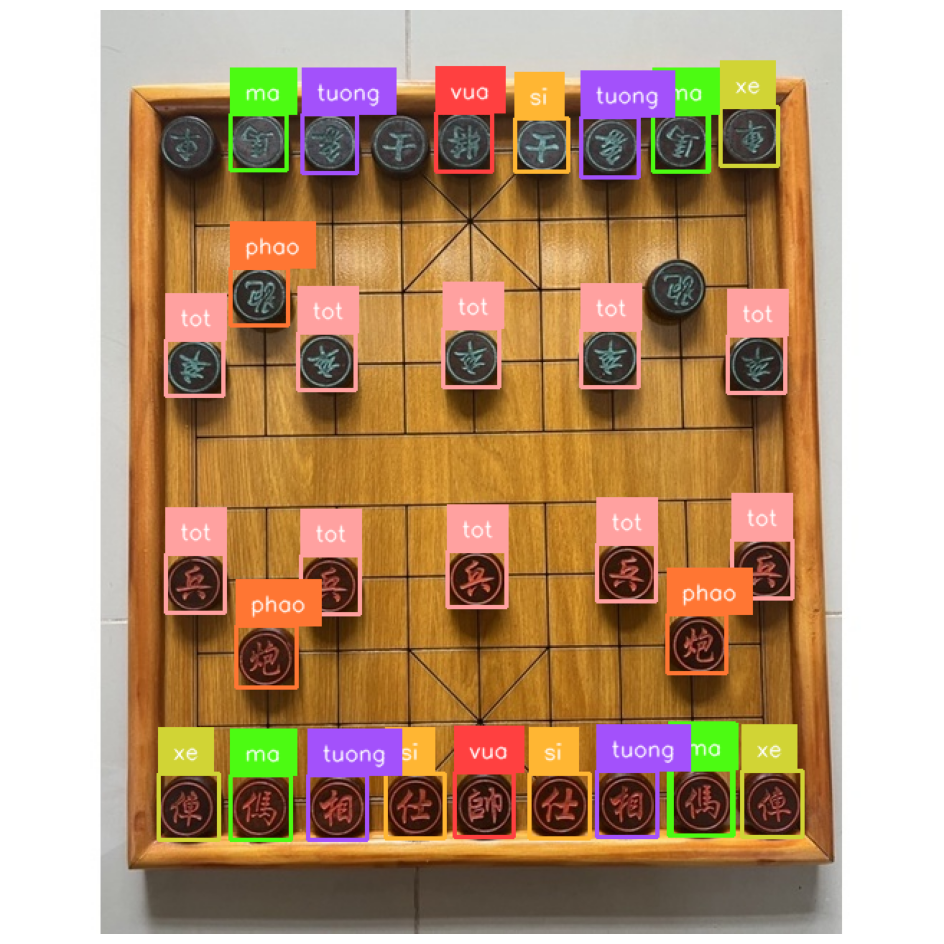

In [16]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)